1. Загрузите датасет taxi.csv.
2. Посмотрите на данные. Отобразите общую информацию по признакам (вспомните о describe и info). Напишите в markdown свои наблюдения.
3. Выявите пропуски, а также возможные причины их возникновения. Решите, что следует сделать с ними. Напишите в markdown свои наблюдения.
4. Оцените зависимости переменных между собой. Используйте корреляции. Будет хорошо, если воспользуетесь profile_report. Напишите в markdown свои наблюдения.
5. Определите стратегию преобразования категориальных признаков (т.е. как их сделать адекватными для моделей).
6. Найдите признаки, которые можно разделить на другие, или преобразовать в другой тип данных. Удалите лишние, при необходимости.
7. Разделите выборку на обучаемую и тестовую.
8. Обучите модель. Напишите в markdown свои наблюдения по полученным результатам. Хорошие результаты дают классификаторы RandomForest и XGBoost

In [24]:
#импортируем все библиотеки, которые нам понадобятся для задания
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

import pandas as pd
from catboost import CatBoostClassifier
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV
from geopy.distance import geodesic
from geopy.distance import great_circle

In [69]:
#открываем файл для получения первичной информации
data = pd.read_csv('taxi.csv')
data.head()

,offer_gk,weekday_key,hour_key,driver_gk,order_gk,driver_latitude,driver_longitude,origin_order_latitude,origin_order_longitude,distance_km,duration_min,offer_class_group,ride_type_desc,driver_response
0,1105373,5,20,6080,174182,55.818842,37.334562,55.814567,37.355010,-1.000,-1.000,Economy,private,0
1,759733,5,14,6080,358774,55.805342,37.515023,55.819329,37.466398,18.802,25.217,Standard,private,1
2,416977,6,14,6080,866260,55.813978,37.347688,55.814827,37.354074,6.747,9.800,Economy,private,0
3,889660,2,6,6080,163522,55.745922,37.421748,55.743469,37.431130,-1.000,-1.000,Economy,private,1
4,1120055,4,16,6080,506710,55.803578,37.521602,55.812559,37.527407,12.383,19.250,Economy,private,1


driver_response - отклик водителя, целевая категориальная переменная.
offer_gk - номер предложения водителям, формируется после оформления ордера. 
Если водитель отказался, формируется новый под тем же ордером.
order_gk - заказ, присваевается сразу
driver_response - реакция водителя/отклик водителя
driver_gk - id водителя
weekday_key - день недели
hour_key - час суток
driver_latitude, longitude - месторасположение водителя на время получения заказа
origin_order_latitude, longitude - месторасположение заказа
distance_km, duration_min, offer_class_group, ride_type_desc - км и время в пути на выполнение, класс, 

In [26]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
offer_gk,100000.0,566218.928650,325935.980081,4.0,285555.250000,565671.500000,848719.750000,1.130355e+06
weekday_key,100000.0,3.159860,2.054222,0.0,1.000000,3.000000,5.000000,6.000000e+00
hour_key,100000.0,13.827790,7.306496,0.0,8.000000,16.000000,20.000000,2.300000e+01
driver_gk,100000.0,3446.376360,2038.738677,14.0,1421.000000,3506.500000,5242.000000,6.806000e+03
order_gk,100000.0,460867.012910,266064.989530,18.0,229178.500000,462420.000000,690894.000000,9.203440e+05
driver_latitude,100000.0,55.700824,2.135903,-1.0,55.708651,55.772904,55.960667,5.617410e+01
driver_longitude,100000.0,37.492292,1.454640,-1.0,37.413497,37.533664,37.624113,3.828055e+01
origin_order_latitude,100000.0,55.772440,0.665985,-1.0,55.708032,55.772561,55.962000,5.631112e+01
origin_order_longitude,100000.0,37.541637,0.467758,-1.0,37.407117,37.532537,37.624358,3.824361e+01
distance_km,100000.0,18.393518,41.129296,-1.0,-1.000000,10.411500,30.665250,5.234283e+03


In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 14 columns):
offer_gk                  100000 non-null int64
weekday_key               100000 non-null int64
hour_key                  100000 non-null int64
driver_gk                 100000 non-null int64
order_gk                  100000 non-null int64
driver_latitude           100000 non-null float64
driver_longitude          100000 non-null float64
origin_order_latitude     100000 non-null float64
origin_order_longitude    100000 non-null float64
distance_km               100000 non-null float64
duration_min              100000 non-null float64
offer_class_group         100000 non-null object
ride_type_desc            100000 non-null object
driver_response           100000 non-null int64
dtypes: float64(6), int64(6), object(2)
memory usage: 10.7+ MB


Аномалии

1. distance и duration  - отрицательные значения

Идеи по предобработке
1. добавить в фичи отдельно выделенные задвоенные ордеры с невыполненными поездками
(посмотреть, возможно они не только задвоены, но и затроены и тд)
2. выделить выбросы в виде отрицательных значений 
(заказы из других городов,возможно, либо неадекватные клиенты)
3. создать дополнительный признак день недели* час суток - в определенные промежутки времени заказов больше/меньше
4. создать дополнительный признак по удаленности водителя от заказа
5. ride_type- посмотреть на варианты и заменить мелкие группы медианами
6. проверить расстояние и время в пути на аномалии с помощью  графиков


driver_response - отклик водителя, целевая категориальная переменная.
offer_gk - номер предложения водителям, формируется после оформления ордера. 
Если водитель отказался, формируется новый под тем же ордером.
order_gk - заказ, присваевается сразу
driver_response - реакция водителя/отклик водителя
driver_gk - id водителя
weekday_key - день недели
hour_key - час суток
driver_latitude, longitude - месторасположение водителя на время получения заказа
origin_order_latitude, longitude - месторасположение заказа
distance_km, duration_min, offer_class_group, ride_type_desc - км и время в пути на выполнение, класс, 

In [70]:
data['dubl_order'] = data.groupby(['order_gk']).cumcount()+1

In [72]:
(data['dubl_order']!=1).sum()/len(data.index)*100

18.565

In [30]:
data[data['dubl_order']>=2][data['driver_response']==0]

/Users/natalaurina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,offer_gk,weekday_key,hour_key,driver_gk,order_gk,driver_latitude,driver_longitude,origin_order_latitude,origin_order_longitude,distance_km,duration_min,offer_class_group,ride_type_desc,driver_response,dubl_order
644,417200,5,15,3929,226107,55.434402,37.872841,55.410307,37.902451,56.688,62.517,Standard,private,0,2
748,133552,4,22,3929,518050,55.452322,37.859236,55.410307,37.902451,-1.000,-1.000,Economy,business,0,2
2015,865055,5,23,6792,163284,55.417123,37.896658,55.410307,37.902451,43.166,53.417,Economy,private,0,2
2024,165301,5,23,6792,626429,55.415417,37.898268,55.410307,37.902451,50.189,58.650,Economy,private,0,2
2025,210712,5,23,6792,292442,55.415417,37.898268,55.410307,37.902451,53.358,54.683,Standard,private,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,726210,0,2,2442,27360,55.961246,37.413497,55.966694,37.415754,17.378,29.817,Economy,private,0,4
99996,881472,0,1,2442,381960,55.961246,37.413497,55.964892,37.413543,7.751,12.683,Economy,private,0,2
99997,626673,1,20,2442,627126,55.961315,37.413497,55.962203,37.416373,46.983,46.217,Standard,private,0,6
99998,672584,6,21,2442,140623,55.961354,37.413864,55.964892,37.413543,50.029,51.100,Economy,private,0,6


In [73]:
(data['duration_min']==-1).sum()

26207

In [74]:
data['driver_gk'].nunique()

439

In [75]:
data['delete'] = data['duration_min'] == -1
data.head()

,offer_gk,weekday_key,hour_key,driver_gk,order_gk,driver_latitude,driver_longitude,origin_order_latitude,origin_order_longitude,distance_km,duration_min,offer_class_group,ride_type_desc,driver_response,dubl_order,delete
0,1105373,5,20,6080,174182,55.818842,37.334562,55.814567,37.355010,-1.000,-1.000,Economy,private,0,1,True
1,759733,5,14,6080,358774,55.805342,37.515023,55.819329,37.466398,18.802,25.217,Standard,private,1,1,False
2,416977,6,14,6080,866260,55.813978,37.347688,55.814827,37.354074,6.747,9.800,Economy,private,0,1,False
3,889660,2,6,6080,163522,55.745922,37.421748,55.743469,37.431130,-1.000,-1.000,Economy,private,1,1,True
4,1120055,4,16,6080,506710,55.803578,37.521602,55.812559,37.527407,12.383,19.250,Economy,private,1,1,False


In [76]:
#data.loc[data['distance_km']==-1, 'distance_km'] = np.nan
#data.loc[data['duration_min']==-1, 'duration_min'] = np.nan

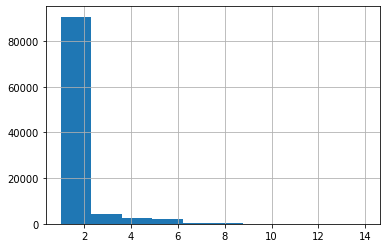

In [35]:
data['dubl_order'].hist()

Допустимо, что заказ может дублироваться пусть 2-3 раза (кто-то выполнил, кто-то отказался, но выбросы показывают, что есть и те, которые дублируются более 10 раз. Возьмем с выбросом 14 и посмотрим более подробно

In [79]:
#вместо удаления строк и столбцов - ДЛЯ МЕНЯ ВЫНЕСТИ КУДА-НИБУДЬ
data_new = data[~((data['driver_response']==0) & (data['dubl_order']>=2))]
data_new.head()


,offer_gk,weekday_key,hour_key,driver_gk,order_gk,driver_latitude,driver_longitude,origin_order_latitude,origin_order_longitude,distance_km,duration_min,offer_class_group,ride_type_desc,driver_response,dubl_order,delete
0,1105373,5,20,6080,174182,55.818842,37.334562,55.814567,37.355010,-1.000,-1.000,Economy,private,0,1,True
1,759733,5,14,6080,358774,55.805342,37.515023,55.819329,37.466398,18.802,25.217,Standard,private,1,1,False
2,416977,6,14,6080,866260,55.813978,37.347688,55.814827,37.354074,6.747,9.800,Economy,private,0,1,False
3,889660,2,6,6080,163522,55.745922,37.421748,55.743469,37.431130,-1.000,-1.000,Economy,private,1,1,True
4,1120055,4,16,6080,506710,55.803578,37.521602,55.812559,37.527407,12.383,19.250,Economy,private,1,1,False


остались еще выбросы. Посмотрим, есть ли у нас дубликаты с driver_response==0 и удалим их

Аномалии: 
1) водитель сначала согласился, а затем отказался (скорее всего) если дистанция и время маленькие зачтены. 
Для построения модели их надо будет распределить в другие места (если переменная = 0)
водитель мог узнать куда ехать потом
2)

In [37]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
offer_gk,100000.0,566218.928650,325935.980081,4.0,285555.250000,565671.500000,848719.750000,1.130355e+06
weekday_key,100000.0,3.159860,2.054222,0.0,1.000000,3.000000,5.000000,6.000000e+00
hour_key,100000.0,13.827790,7.306496,0.0,8.000000,16.000000,20.000000,2.300000e+01
driver_gk,100000.0,3446.376360,2038.738677,14.0,1421.000000,3506.500000,5242.000000,6.806000e+03
order_gk,100000.0,460867.012910,266064.989530,18.0,229178.500000,462420.000000,690894.000000,9.203440e+05
driver_latitude,100000.0,55.700824,2.135903,-1.0,55.708651,55.772904,55.960667,5.617410e+01
driver_longitude,100000.0,37.492292,1.454640,-1.0,37.413497,37.533664,37.624113,3.828055e+01
origin_order_latitude,100000.0,55.772440,0.665985,-1.0,55.708032,55.772561,55.962000,5.631112e+01
origin_order_longitude,100000.0,37.541637,0.467758,-1.0,37.407117,37.532537,37.624358,3.824361e+01
distance_km,73793.0,25.280972,45.949763,0.0,7.901000,18.607000,38.752000,5.234283e+03


Аномалии:
1) не могут быть значения времени и дистанций отрицательными, даже если водитель от поездки отказался.
2) ride_type_desc не отразился, посмотрим его значения

Идеи по предобработке:
1. округлить в большую/меньшую сторону
2. изменить количество вариантов
3. исключить выбросы,  заменить медианами - с боксплот
4. через боксплот посмотреть отдельно зависимость таргета от главного признака(как комнаты и продажа)
5.

In [38]:
data['ride_type_desc'].value_counts()

private      91207
business      8533
affiliate      224
SMB             36
Name: ride_type_desc, dtype: int64

In [80]:
data['driver_client_distance'] = data.apply(lambda x: great_circle((x['origin_order_latitude'], x['origin_order_longitude']), (x['driver_latitude'], x['driver_longitude'])).km, axis=1)
data_new['driver_client_distance'] = data_new.apply(lambda x: great_circle((x['origin_order_latitude'], x['origin_order_longitude']), (x['driver_latitude'], x['driver_longitude'])).km, axis=1)


/Users/natalaurina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [40]:
data.head()

,offer_gk,weekday_key,hour_key,driver_gk,order_gk,driver_latitude,driver_longitude,origin_order_latitude,origin_order_longitude,distance_km,duration_min,offer_class_group,ride_type_desc,driver_response,dubl_order,delete,driver_client_distance
0,1105373,5,20,6080,174182,55.818842,37.334562,55.814567,37.355010,NaN,NaN,Economy,private,0,1,True,1.363047
1,759733,5,14,6080,358774,55.805342,37.515023,55.819329,37.466398,18.802,25.217,Standard,private,1,1,False,3.413097
2,416977,6,14,6080,866260,55.813978,37.347688,55.814827,37.354074,6.747,9.800,Economy,private,0,1,False,0.410000
3,889660,2,6,6080,163522,55.745922,37.421748,55.743469,37.431130,NaN,NaN,Economy,private,1,1,True,0.647473
4,1120055,4,16,6080,506710,55.803578,37.521602,55.812559,37.527407,12.383,19.250,Economy,private,1,1,False,1.062483


In [41]:
#?????как показать только 224, чтобы посчитать %???
#(data[data['ride_type_desc']=='affiliate']).sum
#/data.shape

private - приватные заказы, составляет основную часть заказов
business - бизнес-заказы, составляет 8% 
affiliate - заказы работников компании , составляют всего 0,2% от общих, можно отнести к бизнес-заказам
SMB - менее 1%, тоже можно перенести в бизнес-заказы. 
Но для того, более точного распределения надо посмотреть, в какое время и день недели они совершались,
создать новую переменную, которая будет иметь вес время*день и посмотреть ее значения по заказам private и бизнеса. Далее она пригодится нам , чтобы понимать, когда чаще всего водители берутся за заказ.


надо придумать новую фичу - расстояние между водителем и клиентом по широте и долготе

In [42]:
#это сгруппировали, чтобы только посмотреть
data.groupby(['weekday_key', 'hour_key']).agg({'driver_response': ['mean', 'count']})

driver_response      
                                mean count
weekday_key hour_key                      
0           0               0.352185  1167
            1               0.456790   648
            2               0.462523   547
            3               0.409091   440
            4               0.325726   482
            5               0.292683   410
            6               0.316176   272
            7               0.472393   163
            8               0.470000   200
            9               0.669528   233
            10              0.669014   284
            11              0.678788   330
            12              0.693931   379
            13              0.580169   474
            14              0.570000   500
            15              0.567708   576
            16              0.500000   676
            17              0.489614   674
            18              0.485507   690
            19              0.455726   847
            20              0.425926   864
            21              0.315094  1060
            22              0.244308  1142
            23              0.207687  1353
1           0               0.125466  1610
            1               0.217105   608
            2               0.252577   388
            3               0.188755   249
            4               0.144050   479
            5               0.218543   302
            6               0.356322   261
            7               0.600467   428
            8               0.587065   603
            9               0.702929   478
            10              0.740845   355
            11              0.735661   401
            12              0.788360   378
            13              0.737838   370
            14              0.720513   390
            15              0.631466   464
            16              0.667327   505
            17              0.653772   517
            18              0.544160   702
            19              0.547117   711
            20              0.472703   751
            21              0.467463   753
            22              0.518182   550
            23              0.234450   836
2           0               0.264090   621
            1               0.333333   288
            2               0.306878   189
            3               0.187500   160
            4               0.306667   150
            5               0.224390   205
            6               0.406091   197
            7               0.652459   305
            8               0.684109   516
            9               0.748527   509
            10              0.764579   463
            11              0.767981   431
            12              0.791284   436
            13              0.734118   425
            14              0.700210   477
            15              0.683305   581
            16              0.654545   605
            17              0.594059   707
            18              0.545347   849
            19              0.549878   822
            20              0.457265   936
            21              0.464706  1020
            22              0.372793   963
            23              0.316733  1004
3           0               0.356736   527
            1               0.361446   332
            2               0.430303   165
            3               0.436364   110
            4               0.335821   134
            5               0.304348   138
            6               0.523810   147
            7               0.582245   383
            8               0.621154   520
            9               0.767635   482
            10              0.794521   365
            11              0.772080   351
            12              0.757412   371
            13              0.780723   415
            14              0.796690   423
            15              0.721724   557
            16              0.735556   450
            17              0.695652   575
            18        

In [43]:
#новый столбец - mean_week_hour - среднее количество откликов по дням и часам
data['mean_weekday_hour'] = data['weekday_key']*data['weekday_key']
data.head()

,offer_gk,weekday_key,hour_key,driver_gk,order_gk,driver_latitude,driver_longitude,origin_order_latitude,origin_order_longitude,distance_km,duration_min,offer_class_group,ride_type_desc,driver_response,dubl_order,delete,driver_client_distance,mean_weekday_hour
0,1105373,5,20,6080,174182,55.818842,37.334562,55.814567,37.355010,NaN,NaN,Economy,private,0,1,True,1.363047,25
1,759733,5,14,6080,358774,55.805342,37.515023,55.819329,37.466398,18.802,25.217,Standard,private,1,1,False,3.413097,25
2,416977,6,14,6080,866260,55.813978,37.347688,55.814827,37.354074,6.747,9.800,Economy,private,0,1,False,0.410000,36
3,889660,2,6,6080,163522,55.745922,37.421748,55.743469,37.431130,NaN,NaN,Economy,private,1,1,True,0.647473,4
4,1120055,4,16,6080,506710,55.803578,37.521602,55.812559,37.527407,12.383,19.250,Economy,private,1,1,False,1.062483,16


In [81]:
data_new['mean_weekday_hour'] = data_new['weekday_key']*data['weekday_key']

/Users/natalaurina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [44]:
data['ride_type_desc']

0        private
1        private
2        private
3        private
4        private
          ...   
99995    private
99996    private
99997    private
99998    private
99999    private
Name: ride_type_desc, Length: 100000, dtype: object

In [46]:
#data[data['ride_type_desc']=='affiliate']['age_upon_outcome'].median()

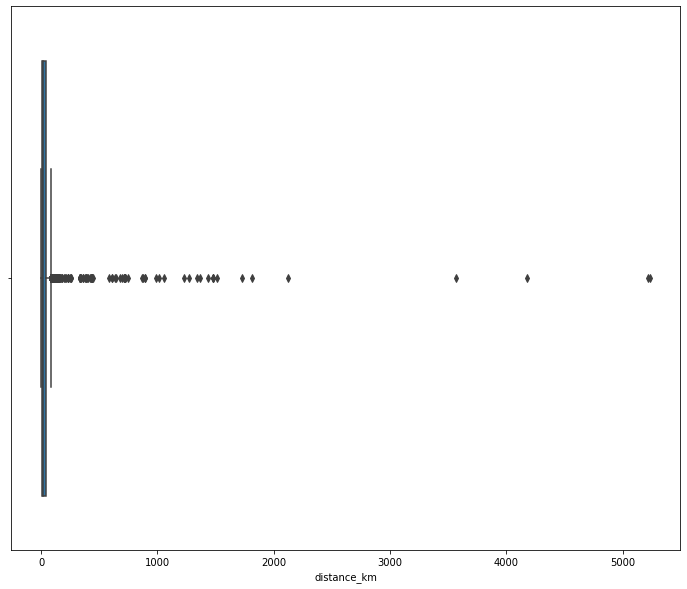

In [68]:
plt.figure(figsize=(12,10))
sns.boxplot(x=data['distance_km'])

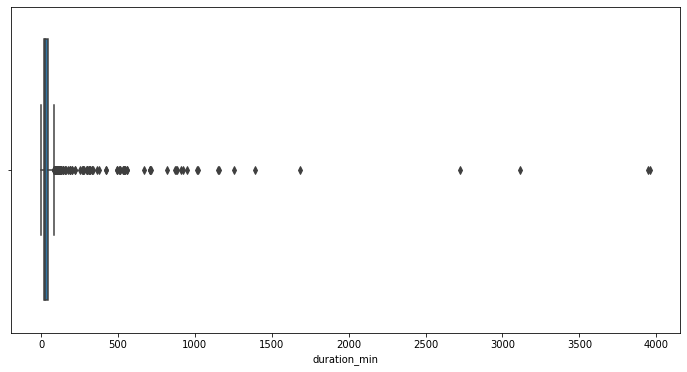

In [48]:
plt.figure(figsize=(12,6))
sns.boxplot(x=data['duration_min'])

Минимальное и максимально и тд

In [49]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 18 columns):
offer_gk                  100000 non-null int64
weekday_key               100000 non-null int64
hour_key                  100000 non-null int64
driver_gk                 100000 non-null int64
order_gk                  100000 non-null int64
driver_latitude           100000 non-null float64
driver_longitude          100000 non-null float64
origin_order_latitude     100000 non-null float64
origin_order_longitude    100000 non-null float64
distance_km               73793 non-null float64
duration_min              73793 non-null float64
offer_class_group         100000 non-null object
ride_type_desc            100000 non-null object
driver_response           100000 non-null int64
dubl_order                100000 non-null int64
delete                    100000 non-null bool
driver_client_distance    100000 non-null float64
mean_weekday_hour         100000 non-null int64
dtypes: bool(

In [50]:
data.isnull().sum()

offer_gk                      0
weekday_key                   0
hour_key                      0
driver_gk                     0
order_gk                      0
driver_latitude               0
driver_longitude              0
origin_order_latitude         0
origin_order_longitude        0
distance_km               26207
duration_min              26207
offer_class_group             0
ride_type_desc                0
driver_response               0
dubl_order                    0
delete                        0
driver_client_distance        0
mean_weekday_hour             0
dtype: int64

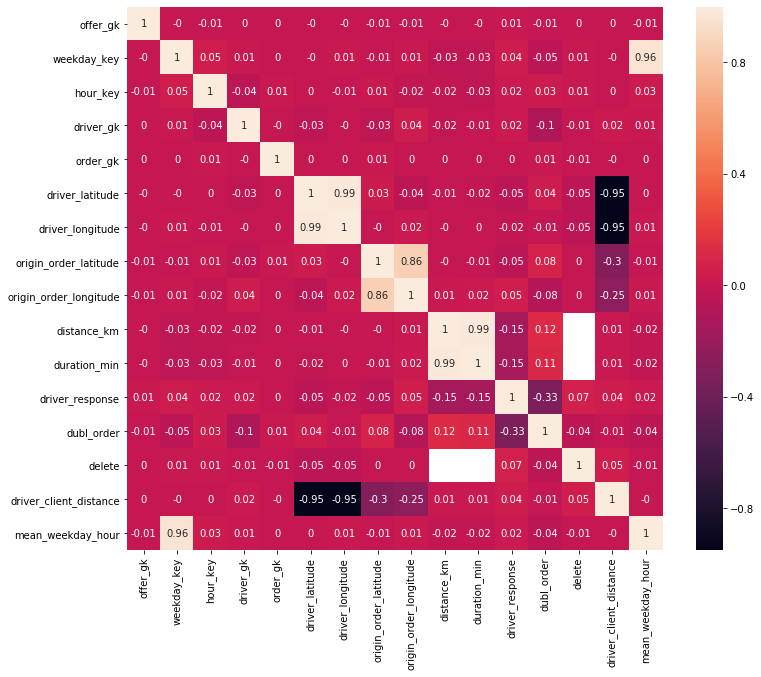

In [51]:
correlation_matrix = data.corr().round(2)
# annot = True to print the values inside the square
fig, ax = plt.subplots(figsize=(12,10)) 
sns.heatmap(data=correlation_matrix, annot=True)

In [82]:

def submit(rgr, x):
    y = pd.Series(rgr.predict(x), index=x.index).to_frame()
    y.to_csv('submit.csv')

разделим признаки на обычные и категориальные

In [83]:
cat_features = ['weekday_key', 'offer_class_group', 'ride_type_desc', 'mean_weekday_hour', 'delete' ]
features = ['hour_key', 'driver_latitude', 'driver_longitude', 'origin_order_latitude', 
            'origin_order_longitude', 'distance_km', 'duration_min', 'dubl_order', 'driver_client_distance'] + cat_features

Покажем, что некоторые из признаков категориальные,чтобы можно было их разместить в Catboost- надо указать их номера столбцов


In [54]:

x, y = data[features], data['driver_response']
cat_features = np.where(x.columns.isin(cat_features))[0]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=31)

In [84]:
x, y = data_new[features], data_new['driver_response']
cat_features = np.where(x.columns.isin(cat_features))[0]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=31)

Функция, которая сама выбирает классификатор или регрессор - R2 или рок аук(можно заменить еще на что то

In [85]:
def score(clf, x_train, x_test, y_train, y_test):
    try:
        y_pred_train, y_pred_test = clf.predict_proba(x_train)[:, 1], clf.predict_proba(x_test)[:, 1]
        print(f'Train-test roc auc: {roc_auc_score(y_train.astype(bool), y_pred_train)}, {roc_auc_score(y_test.astype(bool), y_pred_test)}')
    except AttributeError:
        y_pred_train, y_pred_test = clf.predict(x_train), clf.predict(x_test)
        print(f'Train-test r2 score: {r2_score(y_train, y_pred_train)}, {r2_score(y_test, y_pred_test)}')

In [56]:
'''def score(rgr, x_train, x_test, y_train, y_test):
    y_pred_test = rgr.predict(x_test)
    y_pred_train = rgr.predict(x_train)
    #средняя абсолютная ошибка
    print(f"MAE: \t{mean_absolute_error(y_train, y_pred_train):.2f}\t{mean_absolute_error(y_test, y_pred_test):.2f}")
    print(roc_auc_score(y_train, y_pred_train), roc_auc_score(y_test, y_pred_test))'''

'def score(rgr, x_train, x_test, y_train, y_test):\n    y_pred_test = rgr.predict(x_test)\n    y_pred_train = rgr.predict(x_train)\n    #средняя абсолютная ошибка\n    print(f"MAE: \t{mean_absolute_error(y_train, y_pred_train):.2f}\t{mean_absolute_error(y_test, y_pred_test):.2f}")\n    print(roc_auc_score(y_train, y_pred_train), roc_auc_score(y_test, y_pred_test))'

In [86]:
rgr = CatBoostClassifier(n_estimators=100, learning_rate=0.2, max_depth=4, silent=False, cat_features=cat_features, eval_metric='AUC')
rgr.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_test, y_test)])
score(rgr, x_train, x_test, y_train, y_test)

CatBoostError: Invalid type for cat_feature[non-default value idx=0,feature_idx=12]=9.0 : cat_features must be integer or string, real number values and NaN values should be converted to string.